#### Import packages and set plotting style.

In [ ]:
!pip install tqdm

In [ ]:
import os
import math

import numpy as np
import tensorflow as tf

from tqdm.notebook import trange
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt 

In [ ]:
# Plot Style
sns.reset_defaults()

mpl.style.use('seaborn-colorblind')
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 17
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 4,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (6, 6/1.2) #(7, 7 / 1.61)
})

# Multi-input multi-output Networks (MIMO), Regression Example


In this notebook, we illustrate the idea of Multi-input multi-output Networks (MIMO) in a regression problem. This notebook is broken down into 4 sections:

* Definitions I: **Model & Data**
* Definitions II: **Bias Variance Trade-off**
* Main Experiment: **1D Regression**
* Additional Experiment: **Regression in Higher Dimension**

In section **Model & Data**, we illustrate a simple, minimal implementation of the MIMO model based on MLP, and introduce the data setting we consider (a low-dimensional sinusoidal curve embedded in higher-dimension). Then in section **Bias Variance Trade-off**, we derive the bias variance trade-off mentioned in Section 2 of the paper and provide corresponding python implementations.

In Section **1D Regression**, we reproduce the Figure 2 of the paper. 

Finally as an additinoal study, in Section **Regression in Higher Dimension**, we extend this example beyond 1D to show that similiar phenonmenon holds also in the higher dimension (64D in this notebook). Note that material in this last section is not included in the main text of the paper.


# Definitions I: Model & Data

## Define MIMO Model

As introduced in the paper, a MIMO model is simple to implement: It just involves expanding the dimension of the input and the output layers of an existing model.

In [ ]:
def create_mimo(architecture, data_dim=1, ens_size=1, activation='relu'):
  """Create a MIMO model by expanding input/ouput layer by ensemble size."""
  # The only modification needed by MIMO: expand input/output layer by ensemble size
  num_logits = 1  # Since this is a regression problem.
  inputs_size = data_dim * ens_size
  outputs_size = num_logits * ens_size

  # MIMO input: expand input layer by ensemble size.
  inputs = tf.keras.layers.Input(shape=(inputs_size,))

  # Use the classic MLP encoder.
  net = inputs
  net = tf.keras.layers.Flatten()(net)
  for units in architecture:
    net = tf.keras.layers.Dense(units, activation=activation)(net)

  # MIMO output: Expand output layer by ensemble size.
  outputs = tf.keras.layers.Dense(outputs_size, activation='linear')(net)
  mimo_mlp = tf.keras.models.Model(inputs=inputs, outputs=outputs)
  return mimo_mlp

## Define Data

We consider a regression problem where the low-dimensional regression data is embedded in high-dimensional space. Specifically, we consider the 1D curve example $(x_0, y)$ according to [Blundell et al (2015) (Section 5.2.)](https://arxiv.org/abs/1505.05424), and then project the 1D feature $x_0$ to higher dimension using a random Gaussian projection matrix. 

As a result, the model needs to learn the low-dimensional truth by disentangling the high-dimensional data manifold.

In [ ]:
def create_data(n, data_dim=1, data_noise=0.02, batch_size=64, support=(-1., 1.)):
  """Create regression data from Blundell et al (2016)
  
  Args: 
    n: (int) Sample size.
    data_dim: (int) The dimensionality of the features. 
      A 1D feature will first be created, and if data_dim > 1. It will be 
      projected to data_dim using a random Gaussian matrix.
    data_noise: (float) The standard deviation of the observation noise in the data-generation mechanism.
    batch_size: (int) Batch size for the tf dataset to be generated.
    support: (tuple of float) Range of X to sample the 1D feature from.

  Returns:
    X0: (ndarray) Original 1D features, shape (n, 1)
    y: (ndarray) Response, shape (n, 1)
    X: (ndarray) High-dimensional features obtained by projecting X0 to high dimension, shape (n, data_dim)
    tf_dataset: (tf.data.Dataset) A TF Dataset to be used for training loops.
  """
  # Create 1D features X0.
  lower, upper = support
  X0 = tf.random.uniform((n, 1))* (upper-lower) + lower
  noise = tf.random.normal((n, 1)) * data_noise

  # Generate response. 
  y = X0 + 0.3 * tf.math.sin(2*math.pi * (X0 + noise)) + 0.3 * tf.math.sin(4*math.pi * (X0 + noise)) + noise

  # Embed X0 into high-dimensional space.
  X = X0
  if data_dim > 1:
    Proj_mat = tf.random.normal(shape=(1, data_dim))
    X = tf.matmul(X0, Proj_mat)

  # Produce high-dimensional dataset.
  tf_dataset = tf.data.Dataset.from_tensor_slices((X, y))
  tf_dataset = tf_dataset.shuffle(1024).batch(batch_size)

  return X0, y, X, tf_dataset

Visualize example data: 1D curve embedded in 128D space.

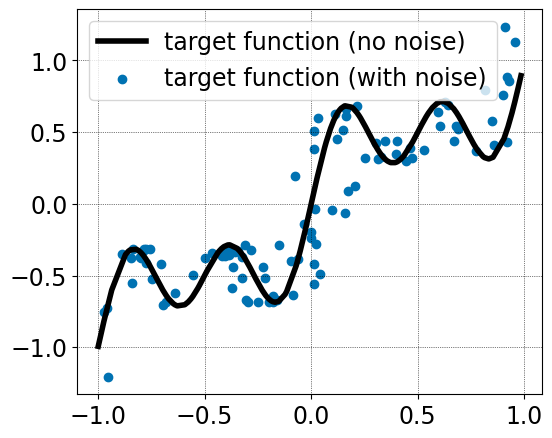

In [ ]:
tf.random.set_seed(100)

X0_noiseless, y_noiseless, _, _ = create_data(200, data_noise=0.0)
argsort = np.argsort(X0_noiseless, 0).flatten()
X0_noiseless = tf.gather(X0_noiseless, argsort)
y_noiseless = tf.gather(y_noiseless, argsort)

X0, y, _, _ = create_data(100, data_noise=0.08)
plt.plot(X0_noiseless, y_noiseless, 'k-', label='target function (no noise)')
plt.scatter(X0, y, label='target function (with noise)')
plt.legend()
plt.show()

## Define Train/Eval Loops

In [ ]:
def get_train_step(ens_size):

  assert ens_size >= 1

  @tf.function
  def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:

      inputs = [x]
      targets = [y]

      for _ in range(ens_size-1):
        rd_index = tf.random.shuffle(tf.range(len(y)))
        shuffled_x = tf.gather(x, rd_index)
        shuffled_y = tf.gather(y, rd_index)
        inputs.append(shuffled_x)
        targets.append(shuffled_y)

      inputs = tf.concat(inputs, 1)
      targets = tf.concat(targets, 1)

      predictions = model(inputs, training=True)
      sq_loss = tf.reduce_mean(tf.square(targets-predictions))

    gradients = tape.gradient(sq_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return sq_loss
  
  return train_step

In [ ]:
def run_mimo_experiments(architecture=(32, 128), ens_sizes=(1, 2, 3, 4, 5),
                         lr=0.01, batch_size=32, n_epochs=2000,
                         data_dim=1, data_noise=0.08, 
                         n_train=64, n_test=3000, num_reps=20,
                         eval_epoch=2, print_epoch=-1):
  """Train MIMO model with different ensemble sizes over multiple random seeds.
  
  Args:
    architecture: (tuple of int) Number of units in each hidden layer the MIMO MLP model.
    ens_sizes: (tuple of int) Ensemble sizes for MIMO model to evaluate in experiments.
    lr: (float) Learning rate.
    batch_size: (int) Batch size used for training.
    n_epochs: (int) Number of training epochs.
    data_dim: (int) Dimensionality of the input features.
    data_noise: (float) The standard deviation of the observation noise in the data-generation mechanism.
    n_train: (int) Number of training examples.
    n_test: (int) Number of test examples.
    num_reps: (int) Number of repetitions to conduct for each ensemble size.
    eval_epoch: (int) Record eval results every eval_epoch.
    print_epoch: (int) Print eval results every print_epoch. Set to -1 to disable.

  Returns: 
    Xtest0: (ndarray) Original 1D features for testing data with support in 
      (-1., 1.), shape (n, 1)
    ytest: (ndarray) Response for testing data, shape (n, 1)
    ytest_pred: (dict) A nested dictionary storing evaluation result for each 
      repetition, each ensemble size, and for specified epochs.
    Xtest0_wide: (ndarray) Similar to Xtest0 but from a testing dataset sampled 
      from a wider support (-2., 2.), shape (n, 1)
    ytest_wide: (ndarray) Similar to ytest but from a wider-support test dataset, 
      shape (n, 1)
    ytest_wide_pred: (dict) Similar to ytest_pred but from a wider-support test 
      dataset.
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Create testing data.
  Xtest0, ytest, Xtest, _ = create_data(n_test, data_dim=data_dim, 
                                   data_noise=data_noise, support=(-1.,1.))
  Xtest0_wide, ytest_wide, Xtest_wide, _ = create_data(n_test, data_dim=data_dim, 
                                             data_noise=data_noise, support=(-2.,2.))

  # Train MIMO models with different ensemble sizes over multiple random seeds.
  ytest_pred = {}
  ytest_wide_pred = {}

  for rep in range(num_reps):
    print('Repetition', rep)

    _, y, X, training_set = create_data(n_train, data_dim=data_dim, 
                                        data_noise=data_noise, batch_size=batch_size)

    ytest_pred[rep] = {}
    ytest_wide_pred[rep] = {}

    for ens_size_id in trange(len(ens_sizes)):
      # Specified ensemble size.
      ens_size = ens_sizes[ens_size_id]

      ytest_pred[rep][ens_size] = {}
      ytest_wide_pred[rep][ens_size] = {}

      # Train a MIMO model.
      optimizer = tf.keras.optimizers.Adam(lr)
      mimo_mlp = create_mimo(architecture, data_dim=data_dim,
                             ens_size=ens_size, activation='relu')
      train_step = get_train_step(ens_size)

      for epoch in range(n_epochs):
        sq_loss = []
        for x, y in training_set:
          loss = train_step(mimo_mlp, optimizer, x, y)
          sq_loss.append(loss)

        if print_epoch > 0 and epoch % print_epoch == 0:
          print('[{:4d}] train sq. loss {:0.3f}'.format(epoch, np.mean(sq_loss)))

        if epoch % eval_epoch == 0:
          # Save testing performance.
          per_ens_member_ytest_pred = mimo_mlp(tf.tile(Xtest, (1, ens_size)))
          ytest_pred[rep][ens_size][epoch] = per_ens_member_ytest_pred

          per_ens_member_ytest_wide_pred = mimo_mlp(tf.tile(Xtest_wide, (1, ens_size)))
          ytest_wide_pred[rep][ens_size][epoch] = per_ens_member_ytest_wide_pred  

  return Xtest0, ytest, ytest_pred, Xtest0_wide, ytest_wide, ytest_wide_pred

# Definitions II: Bias-Variance Trade-off

We have the following setting:


*   The goal is to predict some real-valued target $y$ from input feature vector $x$
*   The training set is denoted by $\mathcal{X} = \{(x_i, y_i)\}_{i=1}^n$ 
*   We denote by $\mathcal{P}$ the joint distribution of $(x, y)$
*   We learn a function $\hat{f}(\cdot; \mathcal{X})$ from the training data to minimize the squared error
$$
\min_{f} \frac{1}{2} \sum_{(x, y) \in \mathcal{X}} (y - f(x))^2
$$
where $f$ will typically be a neural network.
*  We evaluate the performance of $\hat{f}(\cdot; \mathcal{X})$ according to the generalization error
$$
\mathcal{E} = E_{(x, y) \sim \mathcal{P}}\big [\mathcal{E}(x,y) \big]
$$
with
$$
\mathcal{E}(x,y) = E_{\mathcal{X}}\big[ (y - \hat{f}(x; \mathcal{X}) )^2\big]
$$

We can develop $\mathcal{E}$ into the well-known squared bias and variance decompostion. Denoting $\bar{f}(x) = E_{\mathcal{X}}[\hat{f}(x; \mathcal{X})]$, we have:

$
\begin{eqnarray}
E_{\mathcal{X}}\big[ (y - \hat{f}(x; \mathcal{X}) )^2 \big]
&=& 
E_{\mathcal{X}}\big[ (y - \bar{f}(x) + \bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big] \\
&=& 
E_{\mathcal{X}}\big[ (y - \bar{f}(x) + \bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big] \\
&=& 
E_{\mathcal{X}}\big[ (y - \bar{f}(x))^ 2 \big] + 
E_{\mathcal{X}}\big[ (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big]
+
2E_{\mathcal{X}}\big[(y - \bar{f}(x)) (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) ) ] \\
&=& 
(y - \bar{f}(x))^ 2 + 
E_{\mathcal{X}}\big[ (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big] + 0
%\quad(\mathrm{since}\ E_{\mathcal{X}}\big[(y - \bar{f}(x)) (\bar{f}(x) - \hat{f}(x; \mathcal{X}) ) ] = (y - \bar{f}(x)) E_{\mathcal{X}}\big[(\bar{f}(x) - \hat{f}(x; \mathcal{X}) ) ])
\\
&=& 
\mathrm{squared\_bias}(x,y) + \mathrm{variance}(x,y).
\end{eqnarray}
$

We can then readily obtain
$$
\mathcal{E} = E_{(x, y) \sim \mathcal{P}}\big [\mathrm{squared\_bias}(x,y) + \mathrm{variance}(x,y) \big]
$$

In the sequel, we will monitor the value of $\mathcal{E}$ over the course of the optimization, for different ensemble sizes of MIMO.

## Definitions: Squared Bias and Variance

We now consider how to compute the $\mathrm{squared\_bias}(x,y)$ and $\mathrm{variance}(x,y)$ terms using results from a simulation experiment. 

Assume we performed a simulation with $K$ repetitions. In each repetition, we sample a size $n$ dataset $\mathcal{X}_k \sim \mathcal{P}$ and train a model $\hat{f}(x; \mathcal{X}_k)$. We can then estimate the mean prediction as $\bar{f}(x) = \frac{1}{K}\sum_{k=1}^K \hat{f}(x, \mathcal{X}_k)$.

In [ ]:
compute_ens_mean = lambda ens_pred: tf.reduce_mean(ens_pred, axis=1, keepdims=True)

def compute_mean_prediction(y_ens_pred_runs):
  """Computes mean of MIMO model prediction from different experiment runs."""
  ens_pred_list = []
  for y_ens_pred in y_ens_pred_runs.values():
    # Compute mean of ensemble prediction for each repetition
    ens_pred = compute_ens_mean(y_ens_pred)
    ens_pred_list.append(ens_pred)

  return tf.reduce_mean(ens_pred_list, axis=0)

Then, we can estimate the squared bias term and the variance term as below:

$$\mathrm{squared\_bias}(x,y) = (y - \bar{f}(x))^ 2$$

$$\mathrm{variance}(x,y) = E_{\mathcal{X}}\big[ (\bar{f}(x) -  \hat{f}(x; \mathcal{X}) )^2 \big]$$

In [ ]:
def compute_squared_bias(y_test, y_ens_pred_runs):
  """Compute predictive squared bias over experiment repetitions."""
  y_pred_mean = compute_mean_prediction(y_ens_pred_runs)
  return tf.reduce_mean((ytest - y_pred_mean)**2)

def compute_variance(y_ens_pred_runs):
  """Compute predictive variance over experiment repetitions."""
  ens_pred_mean = compute_mean_prediction(y_ens_pred_runs)

  ens_var_list = []
  for y_ens_pred in y_ens_pred_runs.values():
    # Compute variance of ensemble prediction for each repetition
    ens_pred = compute_ens_mean(y_ens_pred)
    ens_var_list.append((ens_pred_mean - ens_pred)**2)

  return tf.reduce_mean(ens_var_list)

Using the above functions, we can write a routine to compute the model bias-variance tradeoff for the simulation experiment.

In [ ]:
def get_simulation_metadata(simu_result):
  """Extract number of repetitions, ensemble sizes and epoch ids from the simulation result."""
  rep_ids = list(simu_result.keys())
  ens_sizes = list(simu_result[rep_ids[0]].keys())
  epoch_ids = list(simu_result[rep_ids[0]][ens_sizes[0]].keys())
  return rep_ids, ens_sizes, epoch_ids
  

def compute_bias_variance_tradeoff(ytest, ytest_pred):
  """Computes bias-variance tradeoff for simulation result contained in ytest_pred."""
  # Extract information about ensemble sizes and epoch ids.
  rep_ids, ens_sizes, epoch_ids = get_simulation_metadata(ytest_pred)

  sq_biases = {}
  variances = {}
  for ens_size in ens_sizes:
    sq_bias_list = []
    var_list = []

    for epoch in epoch_ids:
      # Extract results over repetitions for a specific epoch and ensemble size
      ytest_pred_reps = {rep_id: ytest_pred[rep_id][ens_size][epoch] for rep_id in rep_ids}

      # compute bias and variance
      sq_bias = compute_squared_bias(ytest, ytest_pred_reps)
      variance = compute_variance(ytest_pred_reps)

      sq_bias_list.append(sq_bias)
      var_list.append(variance)

    sq_biases[ens_size] = np.array(sq_bias_list)
    variances[ens_size] = np.array(var_list)
  
  return sq_biases, variances

## Define Visualization Functions

We also implement a plotting routine to visualize the change of bias / variance / losses over the epochs.

In [ ]:
def plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, 
                                plot_type="bias", y_top=None, y_bottom=None, figsize=(9, 6)):
  
  rep_ids, ens_sizes, epoch_ids = get_simulation_metadata(ytest_pred)
  x_axis_epochs = np.array(epoch_ids) + 1

  plt.figure(figsize=figsize)
  for ens_size in ens_sizes:
    if plot_type == "bias":
      plt.plot(x_axis_epochs, np.log10(sq_biases[ens_size]), label='M={}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathrm{squared\ bias})$'
    elif plot_type == "variance": 
      plt.plot(x_axis_epochs, np.log10(variances[ens_size]), label='M={}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathrm{variance})$'
    elif plot_type == "loss":
      plt.plot(x_axis_epochs, np.log10(sq_biases[ens_size] + variances[ens_size]), label='ens. size {}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathcal{E}_{\\mathrm{ens}})$'
    elif plot_type == "loss_diff": 
      single_model_loss = sq_biases[1] + variances[1]
      ensemble_model_loss = sq_biases[ens_size] + variances[ens_size]
      plt.plot(x_axis_epochs, np.log10(ensemble_model_loss) - np.log10(single_model_loss), label='M={}'.format(ens_size))
      plot_ylabel = '$\\log_{10}(\\mathcal{E}_{M})-\\log_{10}(\\mathcal{E}_{1})$'
    else:
      raise ValueError(f"Plot type {plot_type} not supported.")

  plt.legend()
  plt.ylim(top=y_top, bottom=y_bottom)
  plt.xlabel('epochs')
  plt.ylabel(plot_ylabel)
  plt.show()

# Main Experiment: Regression Example 

We now reproduce Figure 2 of the paper. We consider a simulation study with a training and test set of $N_{train}=64$ and $N_{test}=3000$ observations respectively. We train a multilayer perceptron with two hidden-layers, composed of (32, 128) units and ReLU activations. We evaluate both a single model, and MIMO models with ensemble sizes $M=2, \dots, 5$. 

For each ensemble size, we repeat the experiment 20 times and then compute the bias-variance trade-off over the experiment runs.

In [ ]:
experiment_config = dict(
    data_dim=1, 
    architecture=(32, 128),
    n_train=64, 
    n_test=3000, 
    num_reps=20,
    lr=0.01,
    n_epochs=2000, 
    ens_sizes=(1,2,3,4,5))

In [ ]:
Xtest, ytest, ytest_pred, Xtest_wide, ytest_wide, ytest_wide_pred = run_mimo_experiments(**experiment_config)

## Visualize Bias-Variance Trade-off

See Section 2 of the paper for the detailed description. 

Briefly, in this regression setting, we see that as the ensemble size increases, the MIMO model pays a small price in bias but achieves a much larger gain in variance reduction (see the `bias` and then `variance` plots). As a result, MIMO achieves an advantage in generalization error when compared to a single model (see the `loss` and `loss_diff` plots).

In [ ]:
sq_biases, variances = compute_bias_variance_tradeoff(ytest, ytest_pred)

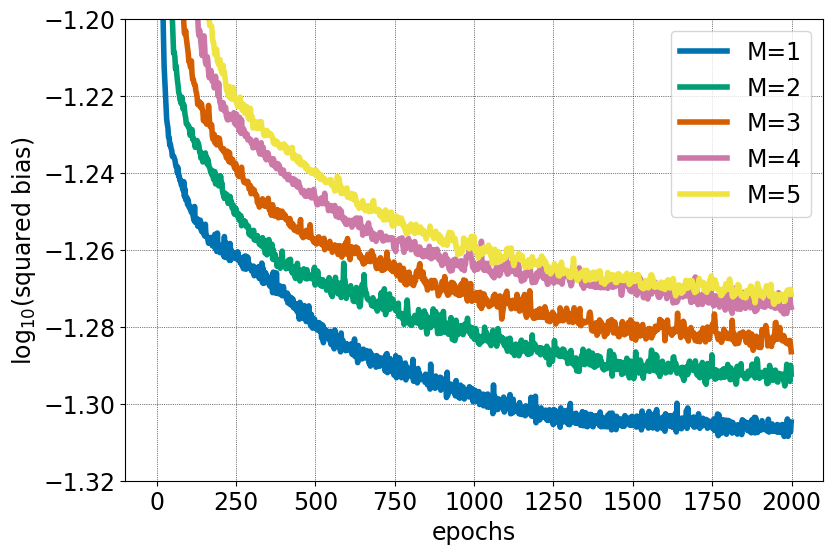

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="bias",
                            y_top=-1.2, y_bottom=-1.32)

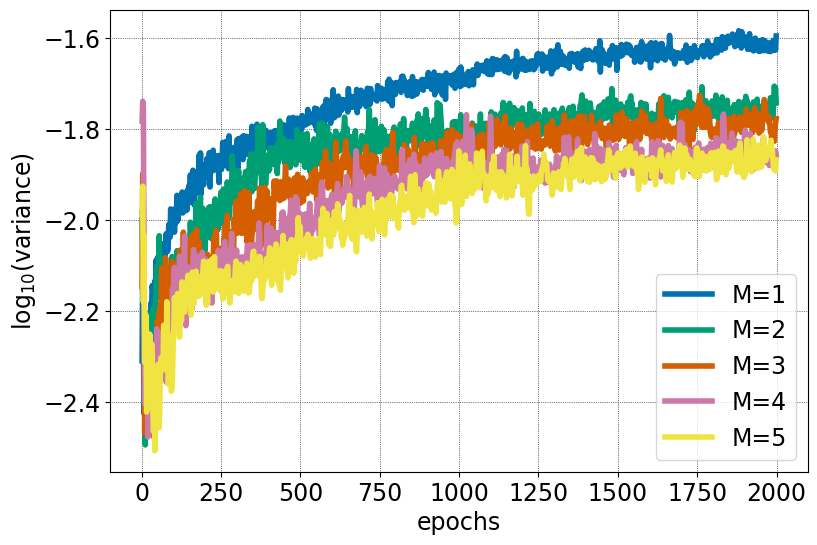

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="variance")

Below two plots compares the generalization error of MIMO to that of a single model. Due to the bias variance trade-off we observed above, MIMO achieves an advantage in generalization error when compared to a single model (see the `loss` and `loss_diff` plots).

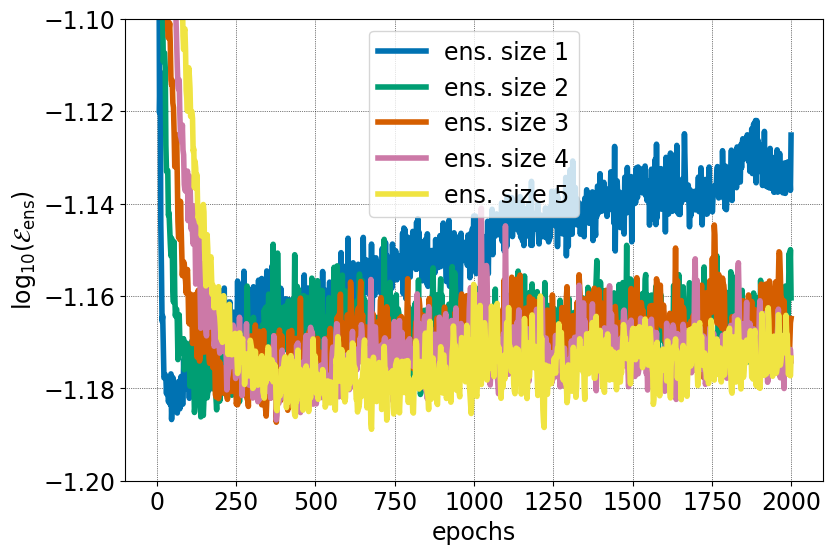

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="loss", 
                            y_top=-1.1, y_bottom=-1.2)

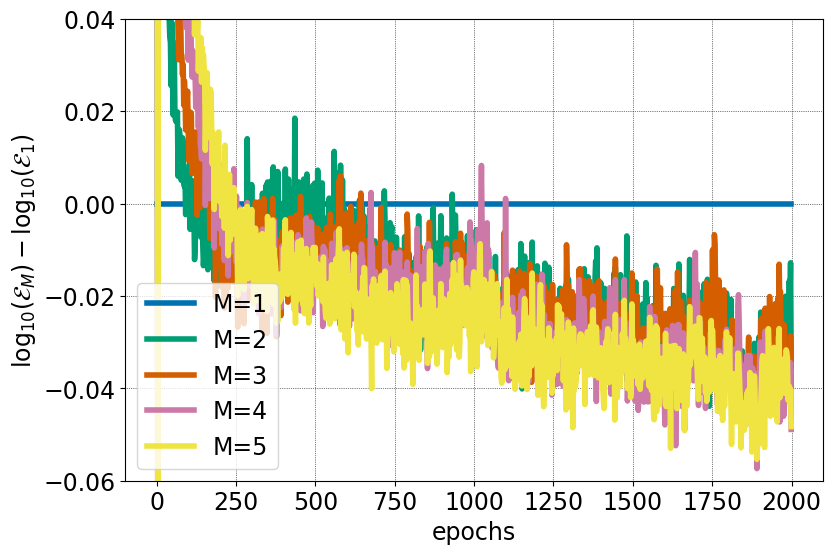

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, 
                            plot_type="loss_diff", y_top=0.04, y_bottom=-0.06)

## Visualize Ensemble Predictions

We can also visualise the predictions of the different MIMO models, at different stages of the training

<Figure size 600x500 with 0 Axes>

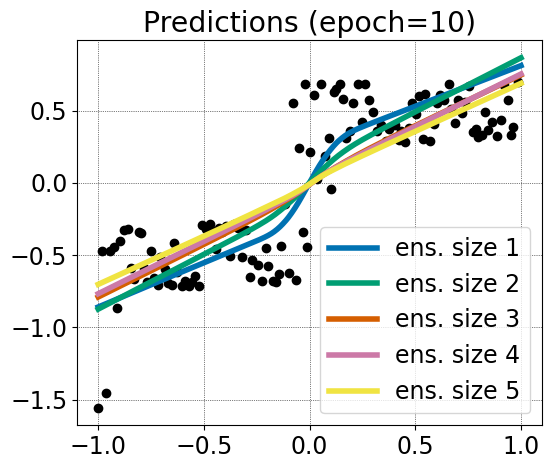

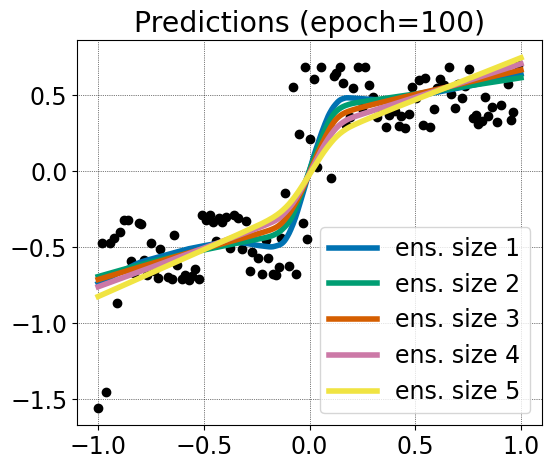

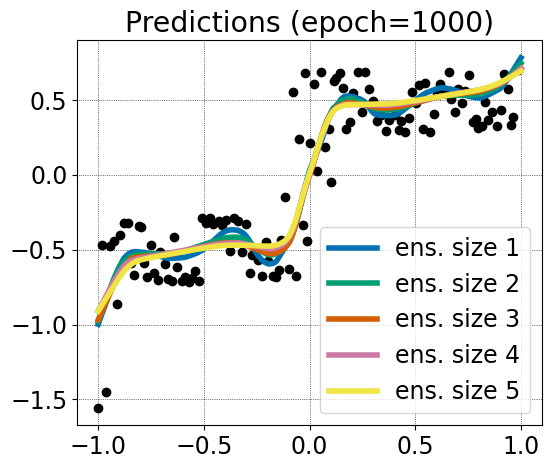

In [ ]:
rep_ids, ens_sizes, epoch_ids = get_simulation_metadata(ytest_pred)

argsort = np.argsort(Xtest, 0).flatten()
subsampled_Xtest = tf.gather(Xtest, argsort[::25])
subsampled_ytest = tf.gather(ytest, argsort[::25])

for epoch in [10, 100, 1000]:
  plt.figure()
  for ens_size in ens_sizes: 
    ytest_pred_reps = {rep_id: ytest_pred[rep_id][ens_size][epoch] for rep_id in rep_ids}
    predictions = compute_mean_prediction(ytest_pred_reps)    
    plt.plot(tf.gather(Xtest, argsort), tf.gather(predictions, argsort), label='ens. size {}'.format(ens_size))
  plt.scatter(subsampled_Xtest, subsampled_ytest, color='k')
  plt.legend()
  plt.title('Predictions (epoch={})'.format(epoch))
  plt.show()


Also visualise the per-member predictions by fixing to a particular seed.

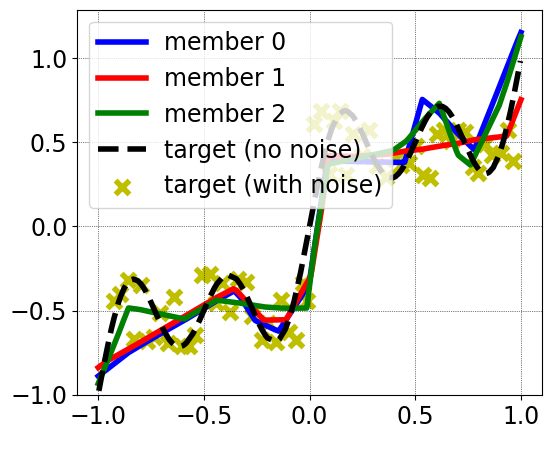

In [ ]:
argsort = np.argsort(Xtest, 0).flatten()
subsampled_Xtest = tf.gather(Xtest, argsort[::50])
subsampled_ytest = tf.gather(ytest, argsort[::50])

ens_size = 3
selected_seed = 2
epoch = 1998

for s in [selected_seed]:
  plt.figure()

  for member_id, c in zip(range(ens_size), ['b', 'r', 'g']): 
    predictions = tf.reduce_mean([ytest_pred[seed][ens_size][epoch][:, member_id] for seed in [s]], 0)
    plt.plot(tf.gather(Xtest, argsort), tf.gather(predictions, argsort), label='member {}'.format(member_id), color=c)

  plt.scatter(subsampled_Xtest, subsampled_ytest, color='y', label='target (with noise)', marker='x', s=100, alpha=1.)

  tf.random.set_seed(666)
  X_noiseless, y_noiseless, _, _ = create_data(200, data_dim=1, data_noise=0.0)
  argsort_noiseless = np.argsort(X_noiseless, 0).flatten()
  X_noiseless = tf.gather(X_noiseless, argsort_noiseless)
  y_noiseless = tf.gather(y_noiseless, argsort_noiseless)
  plt.plot(X_noiseless, y_noiseless, 'k--', label='target (no noise)')

  plt.legend()
  plt.ylim(bottom=-1.)
  plt.xlabel(' ')
  # plt.title('Ensemble member predictions')
  plt.show()

# Additional Experiment: Regression in Higher Dimensions.

We repeat the same experiment, but this time considers a higher-dimensional setting by projecting the 1D feature into higher (64D) dimensions (as introduced in Section **Models & Data**).

### Run experiments

In [ ]:
# We use the same experiment setting as in the 1D experiment, 
# except for changing data dimension from 1 to 64, increase epoch sizes 
# and reduce the frequency for logging results in order to save memory.

experiment_config_highdim = experiment_config
experiment_config_highdim["data_dim"] = 64
experiment_config_highdim["eval_epoch"] = 20
experiment_config_highdim["n_epochs"] = 5000

In [ ]:
Xtest, ytest, ytest_pred, Xtest_wide, ytest_wide, ytest_wide_pred = run_mimo_experiments(**experiment_config_highdim)

Repetition 0



Repetition 1



Repetition 2



Repetition 3



Repetition 4



Repetition 5



Repetition 6



Repetition 7



Repetition 8



Repetition 9



Repetition 10



Repetition 11



Repetition 12



Repetition 13



Repetition 14



Repetition 15



Repetition 16



Repetition 17



Repetition 18



Repetition 19


### Visualized Bias-variance Trade-off in Higher Dimension.

We plot the model bias, variance and generalization error over the epochs as before.

As shown, we observed similar gains in variance for the MIMO model when compared to a single model, with the added advantage that the ensemble predictions are more stable in higher dimension.

In [ ]:
sq_biases, variances = compute_bias_variance_tradeoff(ytest, ytest_pred)

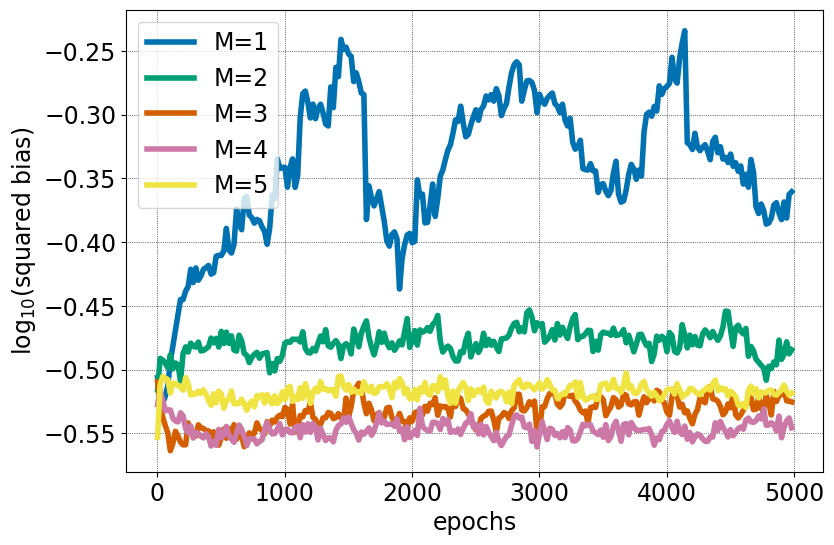

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="bias")

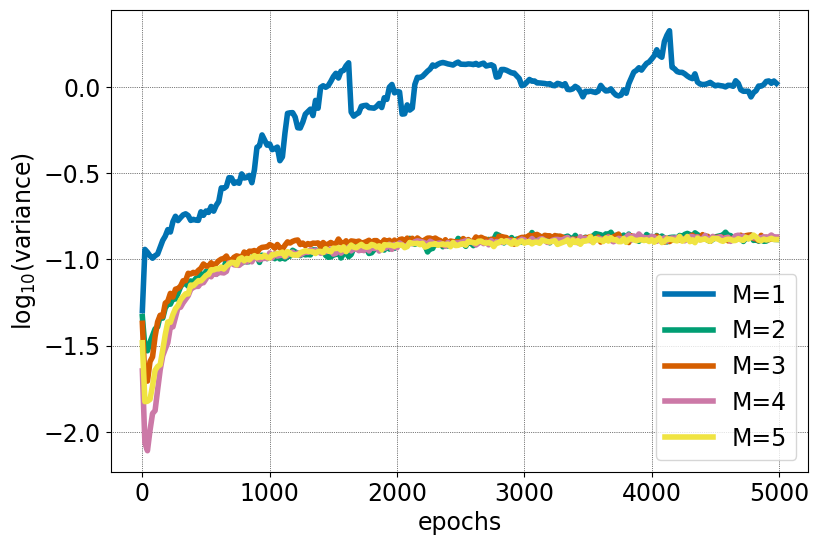

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="variance")

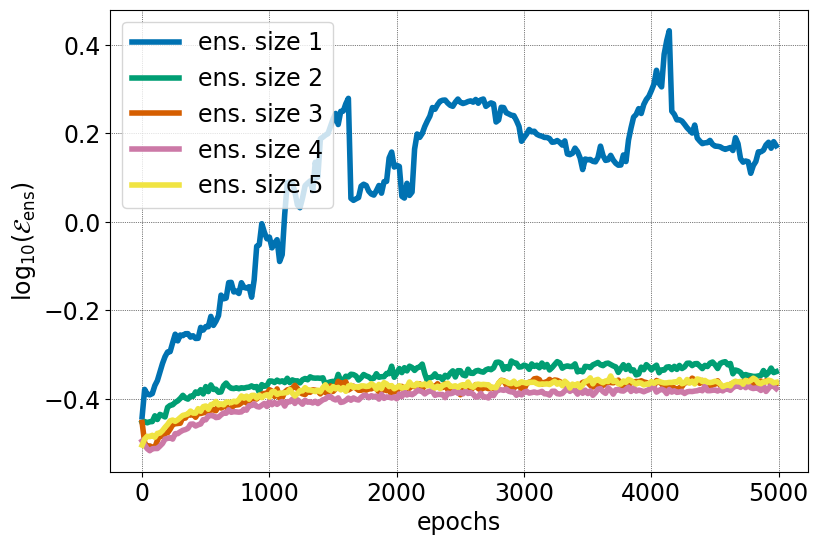

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="loss")

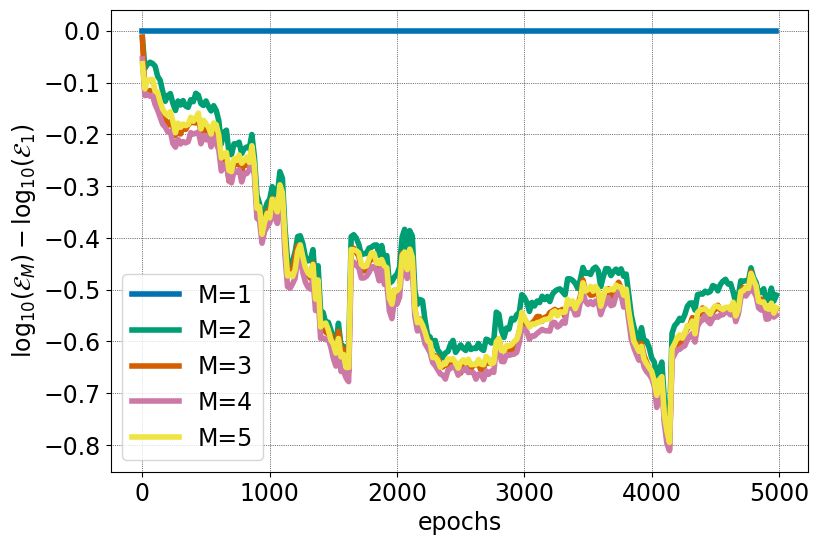

In [ ]:
plot_bias_variance_tradeoff(sq_biases, variances, ytest_pred, plot_type="loss_diff")